## Importing Libraries¶

In [1]:
import cv2
import os
from skimage import color, data, io, measure
from skimage.filters import threshold_otsu
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
mpl.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.dpi']= 300
plt.rc("savefig", dpi=300)
from tqdm import tqdm

In [2]:
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0

    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = False

    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "right-to-left":
        i = 1

    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))

    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

# Find contours for image, which will detect all the boxes
# contours, hierarchy = cv2.findContours(img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# # Sort all the contours by top to bottom.
# (contours, boundingBoxes) = sort_contours(contours, method="top-to-bottom")

In [3]:
def f(y):
    # Defining a kernel length
    global horizontal_lines_img, verticle_lines_img, kernel
    kernel_length = np.array(img).shape[1]//y

    # A verticle kernel of (1 X kernel_length), which will detect all the verticle lines from the image.
    verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
    # A horizontal kernel of (kernel_length X 1), which will help to detect all the horizontal line from the image.
    hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))
    # A kernel of (3 X 3) ones.
    ###kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    # Morphological operation to detect vertical lines from an image
    img_temp1 = cv2.erode(img_bin, verticle_kernel, iterations=1)
    verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=1)
    cv2.imwrite("verticle_lines.jpg",verticle_lines_img)
    # Morphological operation to detect horizontal lines from an image
    img_temp2 = cv2.erode(img_bin, hori_kernel, iterations=1)
    horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=1)
    ###plt.subplot(1, 2, 1)  # 2 rows, 2 columns, 1st subplot = top left
    ###plt.imshow(verticle_lines_img);
    ###plt.axis('off')

    ###plt.subplot(1, 2, 2)  # 2 rows, 2 columns, 2nd subplot = top right
    plt.imshow(horizontal_lines_img);
    plt.axis('off')

# Numbers of Images


In [4]:
import glob
import matplotlib.image as mpimg
%matplotlib inline
images = []
for img_path in glob.glob('img_2/*.jpg'):
    images.append(mpimg.imread(img_path))

In [5]:
len(images)

108

## The images are saved in the folder named as 'img_result'.

 10%|█         | 11/108 [01:46<20:20, 12.58s/it]

KeyboardInterrupt: 

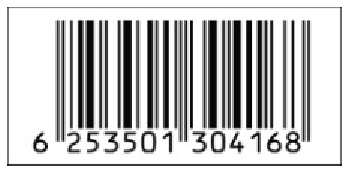

In [6]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

images = []
counter = 1
for img_path in tqdm(glob.glob('img_2/*.jpg')):
    
    img = cv2.imread(img_path,0)
    (thresh, img_bin) = cv2.threshold(img, 240, 255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
    img_bin = 255-img_bin
    f(255)
    alpha = 0.9
    beta = 1.0 - alpha
    # This function helps to add two image with specific weight parameter to get a third image as summation of two image.
    img_final_bin = cv2.addWeighted(verticle_lines_img, alpha, horizontal_lines_img, beta, 0.5)
    #img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=2)
    (thresh, img_final_bin) = cv2.threshold(img_final_bin, 230,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    plt.axis('off')
    plt.imshow(img_final_bin)
#     images.append(mpimg.imread(img_path))
    # Find contours for image, which will detect all the boxes
    contours, hierarchy = cv2.findContours(img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Sort all the contours by top to bottom.
    (contours, boundingBoxes) = sort_contours(contours, method="top-to-bottom")
    idx = 1
    
    for c in (contours):
        # Returns the location and width,height for every contour
        x, y, w, h = cv2.boundingRect(c)
        
# If the box height is greater then 20, widht is >80, then only save it as a box in "cropped/" folder.
        if (w > 160 and h > 80) and w < 2.5 *h:
            idx += 3
            new_img = img[y:y+h, x:x+w]
            #plt.subplot(2,3, idx)
            plt.imshow(new_img)
            plt.axis('off')
            #cv2.imwrite('./th/')
            #path = './th/'
            plt.savefig(f'./img_result/label{counter}.jpg',dpi=300)
            #cv2.imwrite(os.path.join(path , 'label'+str(num)+'.jpg'), new_img)
            #cv2.imwrite(os.path.join(path , 'f', new_img))
            counter+=1
            #cv2.waitKey(0)
    #break

## Extracting text from Nutrition lables

### ---------------

In [7]:
import pytesseract
from PIL import Image, ImageEnhance, ImageFilter
import os
import glob
import re
import sys
import cv2

In [8]:

#sys.path.append('/usr/local/lib/python2.7/site-packages')
## FOR FEW IMAGES ONLY

def writeFile(directory, fileName, content):
    outFile = open('outputs/' + directory + '/' + fileName + '.txt', 'w')
    outFile.write(content)
    outFile.close()

# Setup regex for stripping file names
p = re.compile('[0-9]+.jpg')
    
# Use images in the labels directory
for file in glob.glob('../labels/*.jpg'):
    fileName = p.findall(file)[0]
    print ("Proccessing " + fileName)
    outFileName = fileName[0:len(fileName)-4]
    
    #-----------------------
#     # Get default text recognition 
#     output = pytesseract.image_to_string(Image.open(file))
#     #print(output)

#     # Write default text output to 'outputs/default' directory
#     writeFile('default', outFileName, output)

    # Open image as black and white
    #-----------------------
    
    bw = cv2.imread(file, 0)

    # Apply adaptive thresholding to images
    thresh = cv2.adaptiveThreshold(bw, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY, 11, 2)

    # Get text recognition from thresholded images
    output = pytesseract.image_to_string(Image.fromarray(bw))
    writeFile('bw', outFileName, output)

    break

In [9]:
def label_Recognizer(path):
    import re
#    import end_to_end
    import os
    from matplotlib import pyplot 
    files = []
    # r=root, d=directories, f = files
    for  r,d, f in os.walk(path):
        for file in f:
            files.append(os.path.join(file))
    p = re.compile('[0-9]+.jpg')
    all_result = []
    for f in files:
        print(f)
     #   out_dict = end_to_end.end_to_end(f'{path}\{f}')
        #-----------------
        try:
            for file in glob.glob('./pd_test/*.jpg'):
                fileName = p.findall(file)[0]
                print ("Proccessing " + fileName)
                outFileName = fileName[0:len(fileName)-4]
                # Get default text recognition 
                output = pytesseract.image_to_string(Image.open(file))
                print("/n/sLABEL", output)
                all_result.append(output)
            return all_result
        except:
            
            print('error')
    
            # Write default text output to 'outputs/default' directory
#             writeFile('default', outFileName, output)

#             # Open image as black and white
#             bw = cv2.imread(file, 0)

#             # Apply adaptive thresholding to images
#             thresh = cv2.adaptiveThreshold(bw, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
#                     cv2.THRESH_BINARY, 11, 2)

#             # Get text recognition from thresholded images
#             output = pytesseract.image_to_string(Image.fromarray(bw))
                

#         #-----------------
# #         print('This is out_dict type', type(out_dict))
# #         print(f.replace(r'.jpg',''))
# #         out_dict['Image_id']=f.replace(r'.jpg','')
#             all_result.append(output)
            
#         break

#     df = pd.DataFrame(all_result)
#     df = pd.DataFrame(columns=['Image_id','Nutrient', 'Amount', 'Unit', 'Serving Size','Serving Size Unit','Language'])
#     df_long = df.melt(id_vars=['Serving Size','Image_id'])
#     Units = {'Calories': 'Kcal',
#         'Energy': 'kJ',
#         'Total Fat': 'g',
#         'Saturated Fat': 'g',
#         'Trans Fat': 'g',
#         'Poly Fat': 'g',
#         'Mono Fat': 'g',
#         'Cholesterol': 'mg',
#         'Sodium': 'mg',
#         'Potassium': 'g',
#         'Total Carbohydrate': 'g',
#         'Dietary Fiber': 'g',
#         'Sugars': 'g',
#         'Protein': 'g'}
#     df_long['Serving Size Unit']= 'g'
#     df_long.columns = ['Serving Size','Image_id','Nutrient','Amount','Serving Size Unit']
#     df_long['Unit'] = [Units [x] for x in df_long['Nutrient']]
#     df_long['Language'] = 'English'
#     Final_Outcome = df_long[['Image_id','Nutrient', 'Amount', 'Unit', 'Serving Size','Serving Size Unit','Language']]
#     Final_Outcome.to_excel('DSI-V-Abdulrahman.xlsx', index=False)
#     return Final_Outcome

In [10]:
#####

def label_Recognizer(path):
    import re
    import os
    from matplotlib import pyplot 
    files = []
    for  r,d, f in os.walk(path):
        for file in f:
            files.append(os.path.join(file))
    p = re.compile('[0-9]+.jpg')
    all_result = []
    for f in files:
        print(f)
     #   out_dict = end_to_end.end_to_end(f'{path}\{f}')
        #-----------------

        for file in glob.glob('pd_test/*.jpg'):
            fileName = p.findall(file)[0]
            print ("Proccessing " + fileName)
            outFileName = fileName[0:len(fileName)-4]
            # Get default text recognition 
            output = pytesseract.image_to_string(Image.open(file))
            print("/n/sLABEL", output)
            all_result.append(output)
        result = []
        for i in all_result:
            if len(i) == 0:
                pass
            else:
                result.append(i)
        return result
            


In [22]:
len('')

0

In [ ]:
path = 'pd_test'
files = []
for file in ['label152.jpg', 'label386.jpg', 'label322.jpg', 'label109.jpg']:
            files.append(os.path.join(file))
files[0]

In [15]:
m = label_Recognizer('pd_test')

label152.jpg
Proccessing 152.jpg
/n/sLABEL 
Proccessing 386.jpg
/n/sLABEL ition Facts|!INGREDIENTS:
(28g / about 1" cube) | PASTEURIZED PART-SKIM.
out 8 MILK, CHEESE CULTURE,
SALT, ENZYMES

 
   
  
 
  
 

     
 

 

CONTAINS: MILK.

DISTRIBUTED BY
‘9% | CHURNY COMPANY, INC.
WEYAUWEGA, WI54983 USA

Glu eran ie) 0 oF Ug eh INS

1) wh

O27¢

 

fae
KEEP AERIERATD
Proccessing 322.jpg
/n/sLABEL Nutrition Facts
A Amount Per Serving 1oz (289)
A Galories 175 Calories From Fat 125
Total Fat 14g 22%
Saturated Fat 2.19 11%
Trans Fat Og 0%
Cholesterol Omg 0%
Sodium 23mg 1%
Total Carbohydrate 5g 5%
Dietary Fiber 2.79 119
Protein 7g 14%
Calcium 0%
Iron 3%
VitaminA = 0% Vitamin€ = 2%
Calcium 6% Iron 8%
Percent Daily Values are based on - 2000 calories
diet Your Daily value may be higher or lower
depending on your calorie ne

 

 

 

Aug byllg Syballuc bysylarost
Uno egg

KEEP AWAY FROM HEAT , HUMIDITY
AND SUNLIGHT

MIAN

Mn 7260
Proccessing 109.jpg
/n/sLABEL 


In [21]:
m[2]

'Nutrition Facts\nA Amount Per Serving 1oz (289)\nA Galories 175 Calories From Fat 125\nTotal Fat 14g 22%\nSaturated Fat 2.19 11%\nTrans Fat Og 0%\nCholesterol Omg 0%\nSodium 23mg 1%\nTotal Carbohydrate 5g 5%\nDietary Fiber 2.79 119\nProtein 7g 14%\nCalcium 0%\nIron 3%\nVitaminA = 0% Vitamin€ = 2%\nCalcium 6% Iron 8%\nPercent Daily Values are based on - 2000 calories\ndiet Your Daily value may be higher or lower\ndepending on your calorie ne\n\n \n\n \n\n \n\nAug byllg Syballuc bysylarost\nUno egg\n\nKEEP AWAY FROM HEAT , HUMIDITY\nAND SUNLIGHT\n\nMIAN\n\nMn 7260'

### -------------------

### All_Labels:

In [ ]:

#sys.path.append('/usr/local/lib/python2.7/site-packages')


def writeFile(directory, fileName, content):
    outFile = open('outputs/' + directory + '/' + fileName + '.txt', 'w')
    outFile.write(content)
    outFile.close()

# Setup regex for stripping file names
p = re.compile('[0-9]+.jpg')
    
# Use images in the labels directory
for file in glob.glob('../labels/*.jpg'):
    fileName = p.findall(file)[0]
    print ("Proccessing " + fileName)
    outFileName = fileName[0:len(fileName)-4]
    # Get default text recognition 
    output = pytesseract.image_to_string(Image.open(file))
    #print(output)

    # Write default text output to 'outputs/default' directory
    writeFile('default', outFileName, output)

    # Open image as black and white
    bw = cv2.imread(file, 0)

    # Apply adaptive thresholding to images
    thresh = cv2.adaptiveThreshold(bw, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY, 11, 2)

    # Get text recognition from thresholded images
    output = pytesseract.image_to_string(Image.fromarray(bw))
    writeFile('bw', outFileName, output)

    break

In [ ]:
def label_Recognizer(path):
    import re
#    import end_to_end
    import os
    from matplotlib import pyplot 
    files = []
    # r=root, d=directories, f = files
    for  r,d, f in os.walk(path):
        for file in f:
            files.append(os.path.join(file))
    p = re.compile('[0-9]+.jpg')
    all_result = []
    for f in files:
        print(f)
     #   out_dict = end_to_end.end_to_end(f'{path}\{f}')
        #-----------------
        for file in glob.glob('./img_result/*.jpg'):
            fileName = p.findall(file)[0]
            print ("Proccessing " + fileName)
            outFileName = fileName[0:len(fileName)-4]
            # Get default text recognition 
            output = pytesseract.image_to_string(Image.open(file))
            print("/n", output)
            all_result.append(output)

            # Write default text output to 'outputs/default' directory
#             writeFile('default', outFileName, output)

#             # Open image as black and white
#             bw = cv2.imread(file, 0)

#             # Apply adaptive thresholding to images
#             thresh = cv2.adaptiveThreshold(bw, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
#                     cv2.THRESH_BINARY, 11, 2)

#             # Get text recognition from thresholded images
#             output = pytesseract.image_to_string(Image.fromarray(bw))
                

#         #-----------------
# #         print('This is out_dict type', type(out_dict))
# #         print(f.replace(r'.jpg',''))
# #         out_dict['Image_id']=f.replace(r'.jpg','')
#             all_result.append(output)
            
#         break

    df = pd.DataFrame(all_result)
    df = pd.DataFrame(columns=['Image_id','Nutrient', 'Amount', 'Unit', 'Serving Size','Serving Size Unit','Language'])
    df_long = df.melt(id_vars=['Serving Size','Image_id'])
    Units = {'Calories': 'Kcal',
        'Energy': 'kJ',
        'Total Fat': 'g',
        'Saturated Fat': 'g',
        'Trans Fat': 'g',
        'Poly Fat': 'g',
        'Mono Fat': 'g',
        'Cholesterol': 'mg',
        'Sodium': 'mg',
        'Potassium': 'g',
        'Total Carbohydrate': 'g',
        'Dietary Fiber': 'g',
        'Sugars': 'g',
        'Protein': 'g'}
    df_long['Serving Size Unit']= 'g'
    df_long.columns = ['Serving Size','Image_id','Nutrient','Amount','Serving Size Unit']
    df_long['Unit'] = [Units [x] for x in df_long['Nutrient']]
    df_long['Language'] = 'English'
    Final_Outcome = df_long[['Image_id','Nutrient', 'Amount', 'Unit', 'Serving Size','Serving Size Unit','Language']]
    Final_Outcome.to_excel('DSI-V-Abdulrahman.xlsx', index=False)
    return Final_Outcome

In [ ]:
label_Recognizer('img_result')

In [ ]:
Proccessing 152.jpg
Proccessing 386.jpg
Proccessing 322.jpg
Proccessing 109.jpg

## Referenced_code

In [ ]:
basename = os.path.basename("./img_result")
label_impath = impath.replace(basename, 'tmp_' + basename)
# label_impath = impath.lower().replace('.jpg', 'label_tmp.jpg')
cv2.imwrite(label_impath, label_im)

start = timer()
# Apply Tesseract to image
output = apply_tesseract(label_impath, demo=demo)
#        print ("\n")
output = pytesseract.image_to_string(label_impath,lang='eng')
#     print(arabic)

end = timer()
print('OCR time: %2f' % (end-start))
os.remove(label_impath)

start = timer()
ocr_label = post_process(output, demo=demo)
print(ocr_label)

end = timer()
print('Post process time: %2f' % (end-start))

if show:
    draw_image(label_im, 'Transformed label: %s' % impath)

return ocr_label

### image view

In [ ]:
io.imshow('./test_result.png')

### Text with Tesseract - codes:

In [ ]:

import pytesseract
from PIL import Image, ImageEnhance, ImageFilter

im = Image.open("test_result.png") # the second one 
im = im.filter(ImageFilter.MedianFilter())
enhancer = ImageEnhance.Contrast(im)
im = enhancer.enhance(22)
im = im.convert('1')
im.save('test2.jpg')

text = pytesseract.image_to_string(Image.open('test2.jpg'))
print(text)

#### Method 2

In [ ]:
# A seconde way to extract text - OCR 
import os
import tempfile
import subprocess

def ocr(path):
    temp = tempfile.NamedTemporaryFile(delete=False)

    process = subprocess.Popen(['tesseract', path, temp.name], stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    process.communicate()

    with open(temp.name + '.txt', 'r') as handle:
        contents = handle.read()

    os.remove(temp.name + '.txt')
    os.remove(temp.name)

    return contents

str = ocr('test_result.png')
print(str)